For the following, iterate through the steps you would take to create functions: Write the code to do the following in a jupyter notebook, test it, convert to functions, then create the file to house those functions.

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# import modules
import os
from env import host, user, password

# wrangling
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# exploring
import scipy.stats as stats

# notebook setting configuration
# pd.options.display.float_format = '{:20,.4f}'.format
pd.set_option('display.max_rows', 100)

# Zillow

### Acquire and Summarize
<hr style="border:2px solid gray"> </hr>

#### 1. Acquire Data
>Acquire data from mySQL using the python module to connect and query. You will want to end with a single dataframe. 

Make sure to include: 
- the logerror, 
- all fields related to the properties that are available. You will end up using all the tables in the database.

>Be sure to do the correct join (inner, outer, etc.). We do not want to eliminate properties purely because they may have a null value for airconditioningtypeid.
- Only include properties with a `transaction in 2017`
- Include `only the last transaction for each property` (so - no duplicate property ID's)
- Inlclude along with `zestimate error` and `date of transaction`.
- Only include properties that include a `latitude and longitude value`.

In [13]:
query = '''
SELECT prop.*,
# SELECT ALL FROM PROPERTIES

       pred.logerror, 
       pred.transactiondate, 
       # SELECT LOGERROR AND TRANSACTIONDATE COLUMNS FROM PREDICTIONS
       
       air.airconditioningdesc, 
       arch.architecturalstyledesc, 
       build.buildingclassdesc, 
       heat.heatingorsystemdesc, 
       landuse.propertylandusedesc, 
       story.storydesc, 
       construct.typeconstructiondesc
       #SELECT THESE COLUMNS FROM THESE TABLES

FROM   properties_2017 prop  
       INNER JOIN (SELECT parcelid,
       					  logerror,
                          Max(transactiondate) transactiondate 
                   FROM   predictions_2017
                    # THIS INNER JOIN WILL ONLY RETURN THE RESULTS OF THE TABLES IF THEY HAVE VALUES THAT MATCH TO THE OTHER
                   
                   GROUP  BY parcelid, logerror) pred
                   # THE RESULTS WILL BE GROUPED BY PARCELID (AND LOGERROR?)
               USING (parcelid) 
               # THEY WILL BE JOINED ON THE COLUMN PARCELID
               
       LEFT JOIN airconditioningtype air USING (airconditioningtypeid) 
       LEFT JOIN architecturalstyletype arch USING (architecturalstyletypeid) 
       LEFT JOIN buildingclasstype build USING (buildingclasstypeid) 
       LEFT JOIN heatingorsystemtype heat USING (heatingorsystemtypeid) 
       LEFT JOIN propertylandusetype landuse USING (propertylandusetypeid) 
       LEFT JOIN storytype story USING (storytypeid) 
       LEFT JOIN typeconstructiontype construct USING (typeconstructiontypeid) 
       # THESE LEFT JOINS WILL BE ADDED TO MAIN PROPERTIES TABLE QUERY RESULT IF THEY HAVE A CORRESPONDING VALUE
       
WHERE  prop.latitude IS NOT NULL 
       AND prop.longitude IS NOT NULL AND transactiondate <= '2017-12-31'
       # THIS WILL FILTER OUT ANY RESULTS WHERE THE LAT OR LONG VALUES ARE NULL AND WHERE THE TRANS DATA WAS BEFORE 2018 
        ;
'''

In [14]:
database = 'zillow'

In [15]:
url = f'mysql+pymysql://{user}:{password}@{host}/{database}'

In [16]:
pd.read_sql(query, url)

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,6.059063e+13,0.025595,2017-01-01,None,None,None,None,Single Family Residential,None,None
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,...,6.111001e+13,0.055619,2017-01-01,None,None,None,None,Single Family Residential,None,None
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,6.059022e+13,0.005383,2017-01-01,None,None,None,None,Single Family Residential,None,None
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,...,6.037300e+13,-0.103410,2017-01-01,None,None,None,Central,Single Family Residential,None,None
4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,...,6.037124e+13,0.006940,2017-01-01,Central,None,None,Central,Condominium,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77569,2864704,10833991,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,...,6.037132e+13,-0.002245,2017-09-20,Central,None,None,Central,Condominium,None,None
77570,673515,11000655,NaN,NaN,NaN,2.0,2.0,NaN,6.0,2.0,...,6.037101e+13,0.020615,2017-09-20,None,None,None,Central,Single Family Residential,None,None
77571,2968375,17239384,NaN,NaN,NaN,2.0,4.0,NaN,NaN,2.0,...,6.111008e+13,0.013209,2017-09-21,None,None,None,None,Single Family Residential,None,None
77572,1843709,12773139,1.0,NaN,NaN,1.0,3.0,NaN,4.0,1.0,...,6.037434e+13,0.037129,2017-09-21,Central,None,None,Central,Single Family Residential,None,None


> `acquire_data()` function

General purpose function that will acquire data from a local csv file or sql query

In [22]:
def acquire_data(file_name, database, query):
    '''
THIS FUNCTION TAKES IN:
    (1) A CSV FILE NAME ***MAKE SURE YOU INCLUDE .CSV EXT*** 
    (2) COLUMN FROM TABLE TO BE USED AS DATAFRAME INDEX
    (3) DATABASE NAME AND 
    (4) SQL QUERY STRING 
AND RETURNS A PANDAS DF BY:
        (i.) CHECKING TO SEE IF LOCAL CSV FILE WITH DATA EXISTS
        (ii.) WRITING THE LOCAL CSV FILE OT PANDAS DF 
OR, IF LOCAL CSV DOES NOT EXIST:
        (i.) IMPORTING DATABASE CONNECTION CREDENTIALS
        (ii.) USING CREDENTIALS TO CREATE DATABASE CONNECTION STRING
        (iii.) READING THE SQL QUERY INTO A DF
        (iv.) CACHING DF AND SAVING DATA AS LOCAL CSV FILE
    '''
    # checking for local csv file
    if os.path.isfile(file_name):
        
        # reading csv file to pandas df
        df = pd.read_csv(file_name)
        
    # if no local csv file
    else:

        # url database connection string
        url = f'mysql+pymysql://{user}:{password}@{host}/{database}'

        # reading sql query into df using query, url string, and index_col parameter
        df = pd.read_sql(query, url)
        
        # write df to local csv file
        df.to_csv(file_name)
    
    return df 

In [23]:
zillow_df = acquire_data('zillow.csv', 'zillow', query)

#### 2. Summarize Data

In [69]:
def summarize_data(df):
    '''
    
    '''
    
    preview = df.head()
    
    print('DataFrame Shape'.upper())
    print('-' * len('DataFrame Shape'))
    print(f'Rows: {df.shape[0]}\nColumns: {df.shape[1]}')
    print()
    
    print('DataFrame Info'.upper())
    print('-' * len('DataFrame Info'))
    print(df.info())
    print()
    
    print('Unique Values by Column'.upper())
    print('-' * len('Unique Values by Column'))
    
    for col in df.columns:
        print(col.upper())
        print('-' * len(col))
        print(f'Number of Unique Values for {col}: {df[col].nunique()}')
        
        unique_cols = []
    for col in df.columns:
        if df[col].nunique() <= 10:
            print(col.upper())
            print('-' * len(col))
            print(df[col].value_counts(dropna = False))
            unique_cols.append(col)
            print('_____________________________')
            print()
            
        else:
            print(col.upper())
            print('-' * len(col))
            print('This column has > 10 values')
            print('_____________________________')
            print()
        print()
            
    print('Descriptive Stats'.upper())
    print('-' * len('Descriptive Stats'))
    print(df[unique_cols].describe())
    print()
            
    return preview

In [70]:
summarize_data(zillow_df)

DATAFRAME SHAPE
---------------
Rows: 77574
Columns: 68

DATAFRAME INFO
--------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77574 entries, 0 to 77573
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77574 non-null  int64  
 1   parcelid                      77574 non-null  int64  
 2   airconditioningtypeid         25006 non-null  float64
 3   architecturalstyletypeid      206 non-null    float64
 4   basementsqft                  50 non-null     float64
 5   bathroomcnt                   77574 non-null  float64
 6   bedroomcnt                    77574 non-null  float64
 7   buildingclasstypeid           15 non-null     float64
 8   buildingqualitytypeid         49808 non-null  float64
 9   calculatedbathnbr             76959 non-null  float64
 10  decktypeid                    614 non-null    float64
 11  finishedfloor1squarefeet      60

Number of Unique Values for logerror: 77029
TRANSACTIONDATE
---------------
Number of Unique Values for transactiondate: 264
AIRCONDITIONINGDESC
-------------------
Number of Unique Values for airconditioningdesc: 5
ARCHITECTURALSTYLEDESC
----------------------
Number of Unique Values for architecturalstyledesc: 5
BUILDINGCLASSDESC
-----------------
Number of Unique Values for buildingclassdesc: 2
HEATINGORSYSTEMDESC
-------------------
Number of Unique Values for heatingorsystemdesc: 10
PROPERTYLANDUSEDESC
-------------------
Number of Unique Values for propertylandusedesc: 13
STORYDESC
---------
Number of Unique Values for storydesc: 1
TYPECONSTRUCTIONDESC
--------------------
Number of Unique Values for typeconstructiondesc: 4
ID
--
This column has > 10 values
_____________________________


PARCELID
--------
This column has > 10 values
_____________________________


AIRCONDITIONINGTYPEID
---------------------
NaN     52568
1.0     23185
13.0     1575
5.0       167
11.0       53
9.

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,...,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,...,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,...,6.037124e+13,0.006940,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN


### Nulls

>nulls by column

In [91]:
zillow_df.isnull().sum().sort_values(ascending = False)

buildingclassdesc               77559
buildingclasstypeid             77559
finishedsquarefeet13            77532
storytypeid                     77524
basementsqft                    77524
storydesc                       77524
yardbuildingsqft26              77504
fireplaceflag                   77402
architecturalstyletypeid        77368
architecturalstyledesc          77368
typeconstructiondesc            77352
typeconstructiontypeid          77352
finishedsquarefeet6             77188
pooltypeid10                    77109
decktypeid                      76960
poolsizesum                     76705
pooltypeid2                     76500
hashottuborspa                  76035
yardbuildingsqft17              75181
taxdelinquencyyear              74674
taxdelinquencyflag              74674
finishedsquarefeet15            74547
finishedsquarefeet50            71539
finishedfloor1squarefeet        71539
fireplacecnt                    69287
threequarterbathnbr             67469
pooltypeid7 

In [92]:
zillow_df.shape[0]

77574

In [103]:
def nulls_by_col(df):
    '''
THIS FUNCTION TAKES IN A DATAFRAME AND RETURNS A DATAFRAME WHERE THE FIRST COLUMN SHOWS THE
NUMBER OF NULLS IN EACH COLUMN AND THE SECOND COLUMN SHOWS THE PERCENTAGE OF VALUES IN EACH
COLUMN. THE FINAL DF IS SORTED BY THE PERCENTAGE OF NULLS IN DESCENDING ORDER. 
    '''
    
    num_missing = df.isnull().sum()
    
    rows = df.shape[0]
    
    pct_missing = (num_missing / rows * 100).round(2)
    
    nulls_df = pd.DataFrame({'no_nulls_in_col': num_missing, 'pct_nulls_in_col': pct_missing})\
    .sort_values('pct_nulls_in_col', ascending = False)
    
    return nulls_df

In [104]:
nulls_by_col(zillow_df)[nulls_by_col(zillow_df).no_nulls_in_col > 0]

,no_nulls_in_col,pct_nulls_in_col
buildingclassdesc,77559,99.98
buildingclasstypeid,77559,99.98
finishedsquarefeet13,77532,99.95
storytypeid,77524,99.94
basementsqft,77524,99.94
...,...,...
structuretaxvaluedollarcnt,115,0.15
regionidzip,50,0.06
taxamount,5,0.01
landtaxvaluedollarcnt,2,0.00


>nulls by row

In [105]:
zillow_df.isnull().sum(axis = 1)

0        36
1        33
2        34
3        32
4        29
         ..
77569    29
77570    33
77571    32
77572    32
77573    34
Length: 77574, dtype: int64

In [106]:
zillow_df.isnull().sum(axis = 1).value_counts()

33    14817
34    13356
32    12606
31     9911
36     5793
29     5285
35     5163
37     3630
30     3465
38     1932
28      457
27      316
39      285
40      230
44       79
26       65
45       50
41       29
43       29
42       26
25       24
24       13
46        5
47        3
48        3
23        2
dtype: int64

>There are **`14_817`** rows with '**`33`** nulls column values

In [107]:
def nulls_by_row(df):
    '''
THIS FUNCTION TAKES IN A DATAFRAME AND CREATES THREE COLUMNS THAT DESCRIBE THE DATAFRAMES NULL
VALUES IN EACH ROW:
    (1) COLUMN 1 IS THE COUNT OF NULL VALUE COLUMNS IN THE ROW
    (2) COLUMN 2 IS THE NUMBER OF ROWS THAT HAVE THAT MANY (COL 1) NULLS VALUES
    (3) COLUMN 3 IS THE PERCENTAGE OF NULLS IN THE ROW OF THE TOTAL ROWS
    '''
    
    df2 = pd.DataFrame(df.isnull().sum(axis = 1), columns = ['no_cols_with_nulls']).reset_index().groupby('no_cols_with_nulls').count().reset_index()\
    .rename(columns = {'index': 'no_rows'})
                      
    df2['pct_nulls_in_row'] = df2.no_cols_with_nulls/df.shape[1]
                      
    return df2

In [109]:
nulls_by_row(zillow_df).sort_values(by = 'pct_nulls_in_row', ascending = False)

,no_cols_with_nulls,no_rows,pct_nulls_in_row
25,48,3,0.705882
24,47,3,0.691176
23,46,5,0.676471
22,45,50,0.661765
21,44,79,0.647059
...,...,...,...
4,27,316,0.397059
3,26,65,0.382353
2,25,24,0.367647
1,24,13,0.352941


### Visualize data

In [86]:
def visualize_data(df):
    
    for col in df.columns:
        
        plt.title(f'{col.upper()} Histogram')
        df[col].hist()
        plt.show()
        
    for col in df.columns:
        
        if df[col].dtype != 'O' & df[col] not in ['id', 'parcelid']:
            plt.title(f'{col.upper()} Boxplot')
            sns.boxplot(y = df[col])
            plt.show()
        
        else:
            print(f'{col.upper()} is a categorical column.')

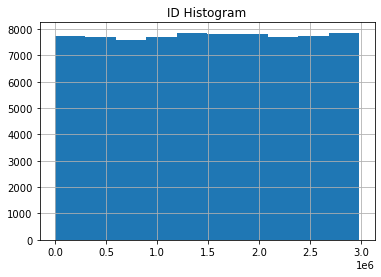

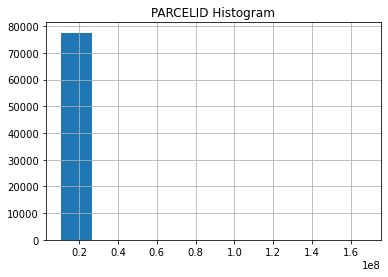

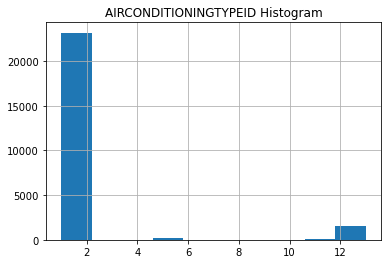

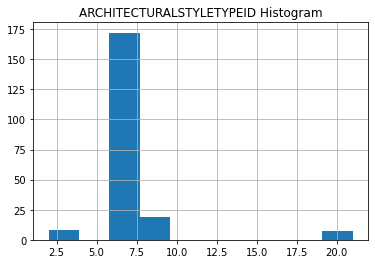

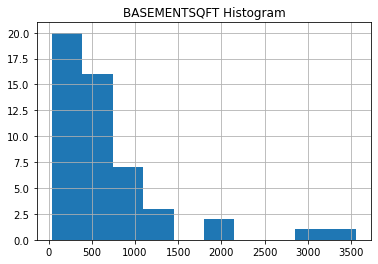

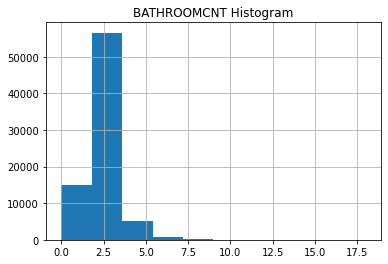

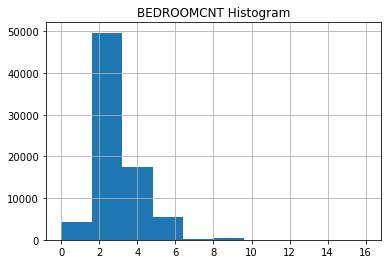

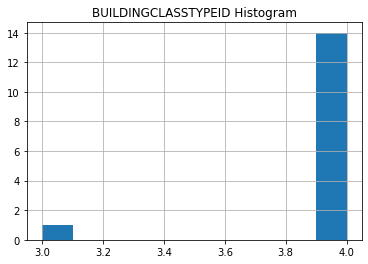

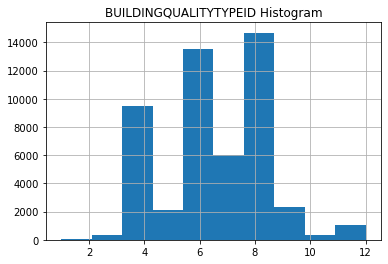

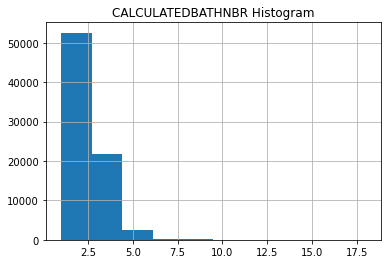

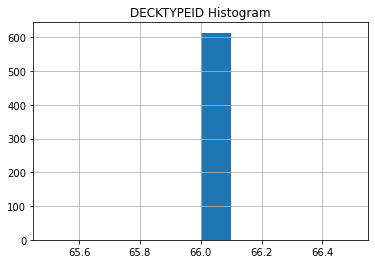

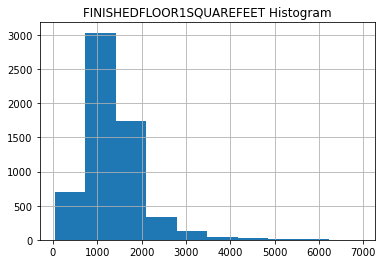

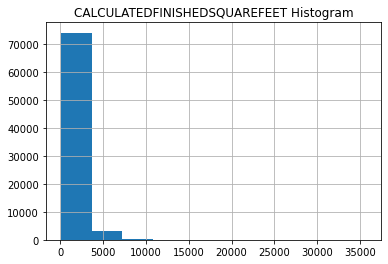

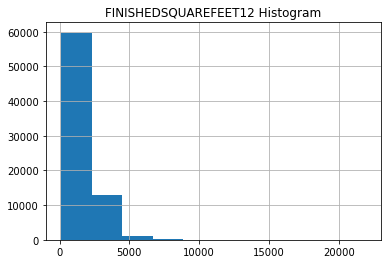

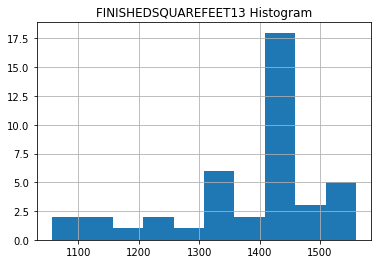

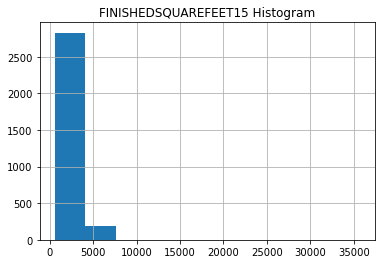

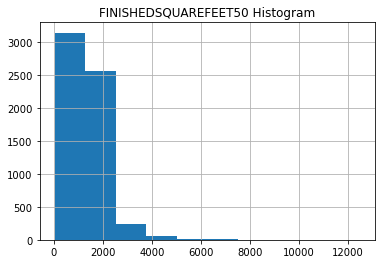

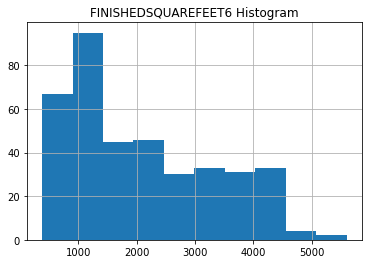

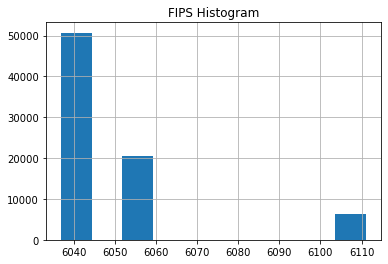

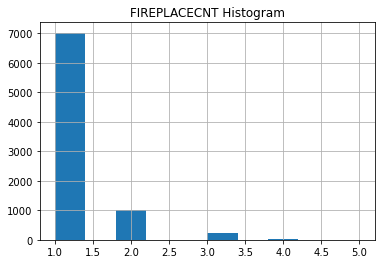

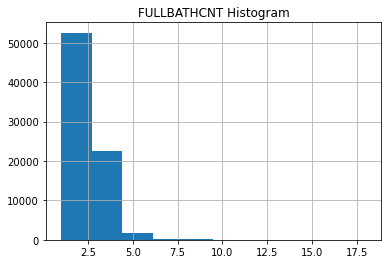

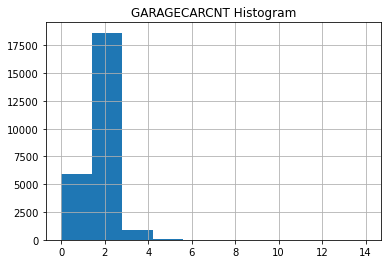

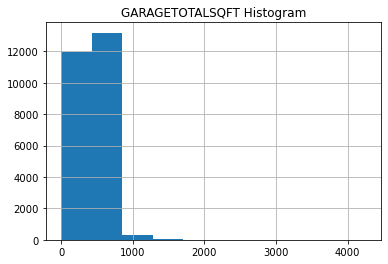

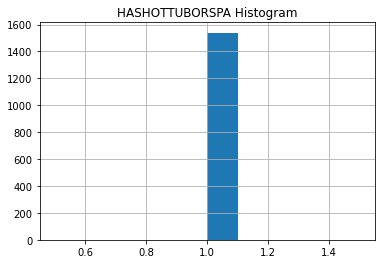

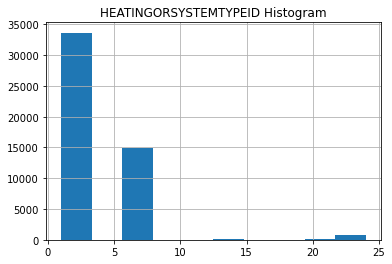

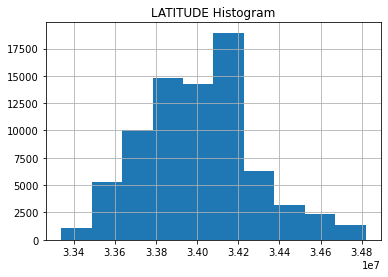

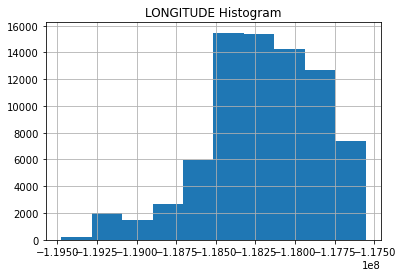

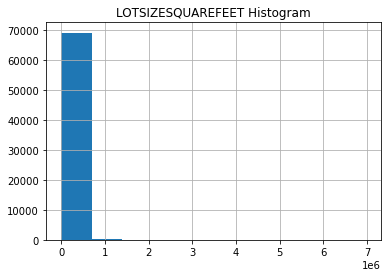

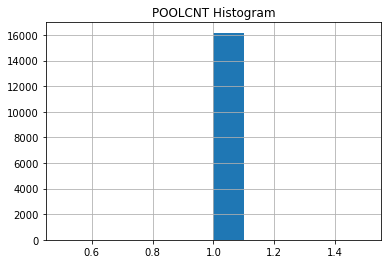

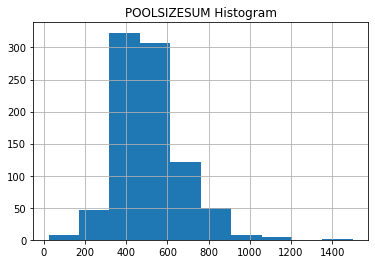

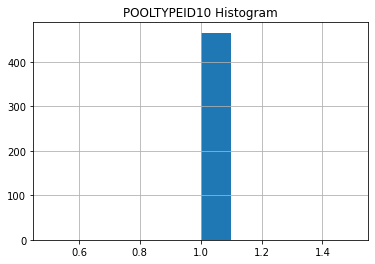

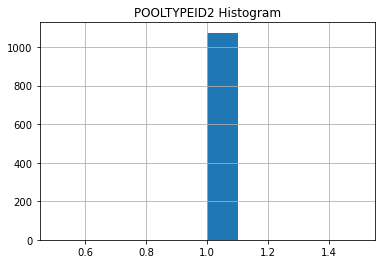

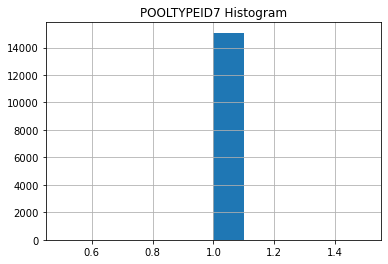

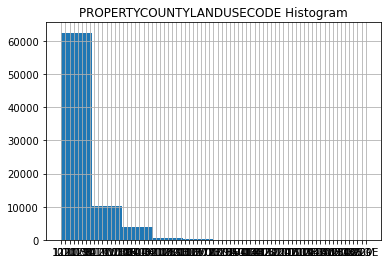

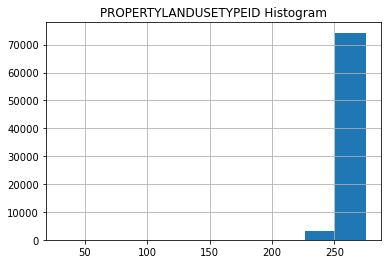

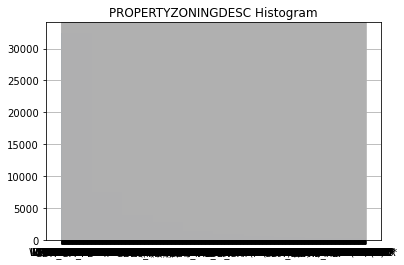

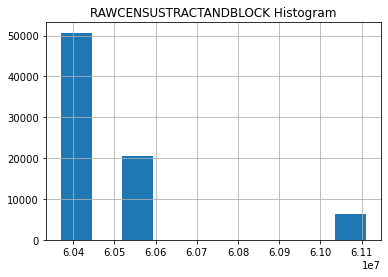

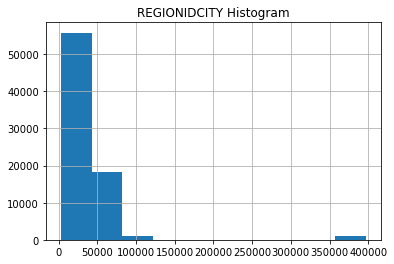

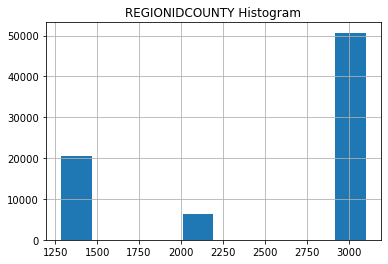

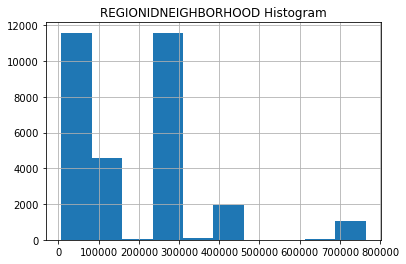

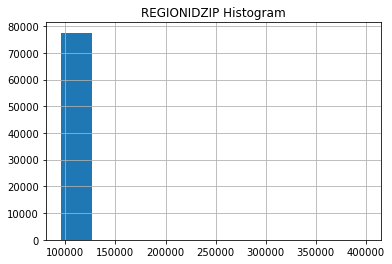

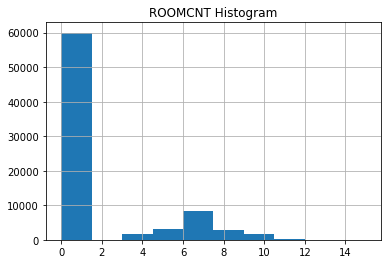

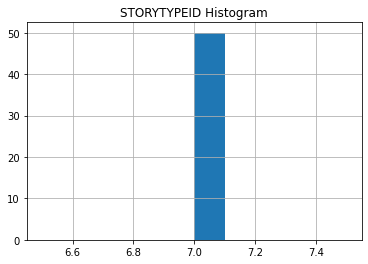

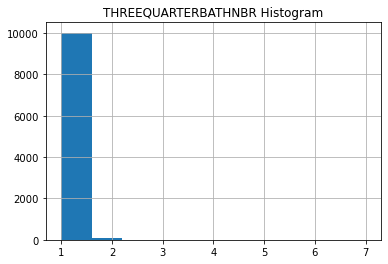

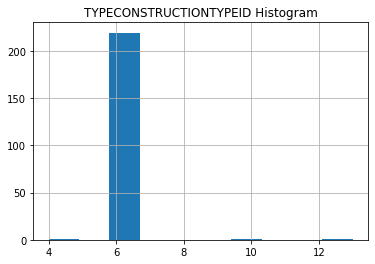

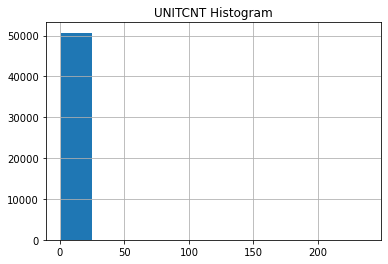

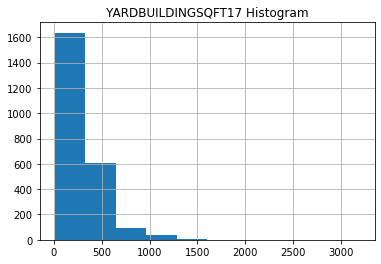

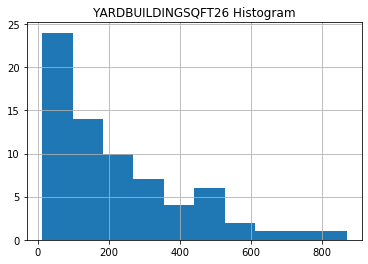

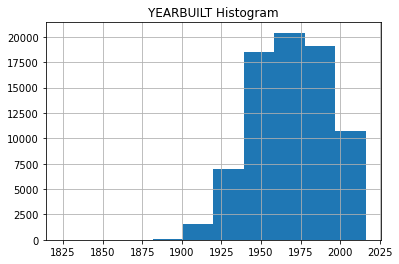

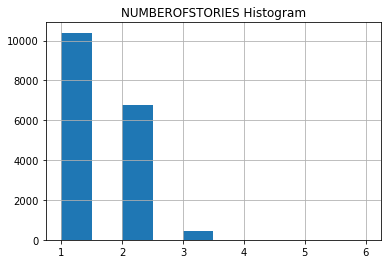

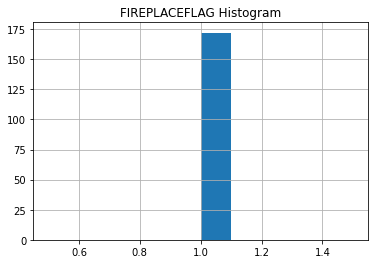

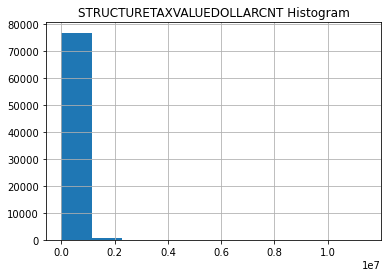

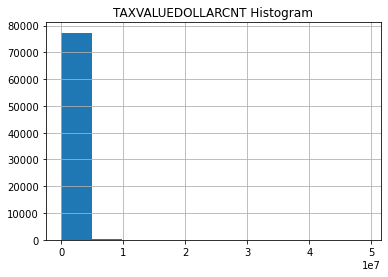

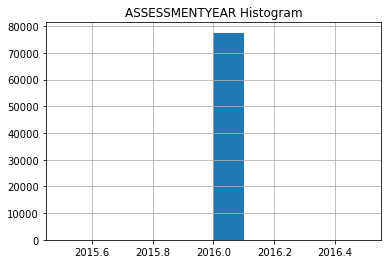

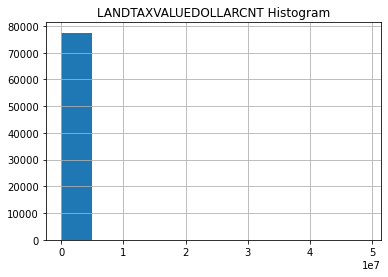

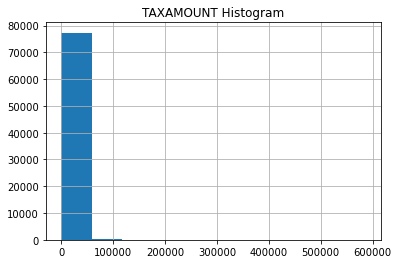

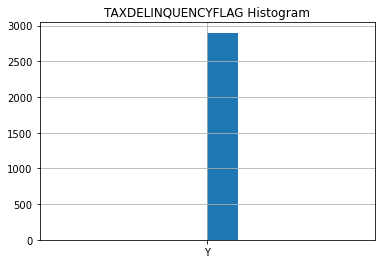

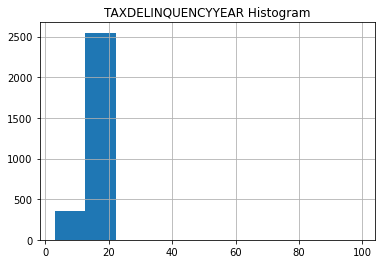

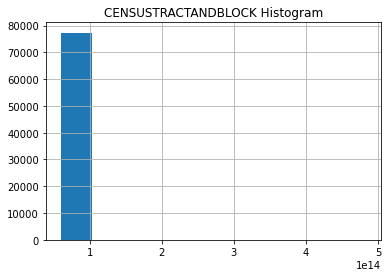

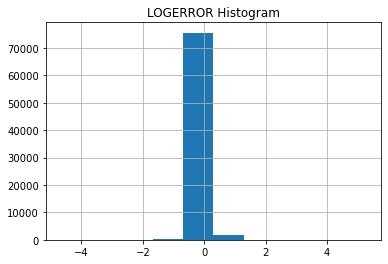

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


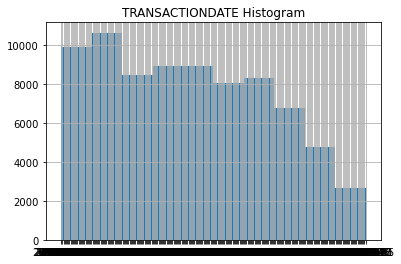

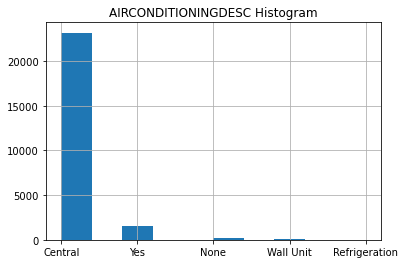

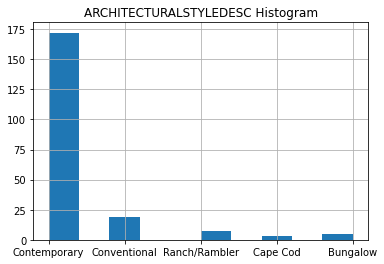

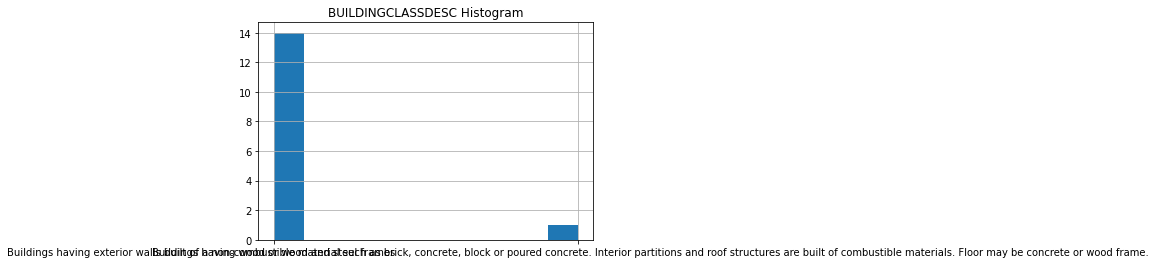

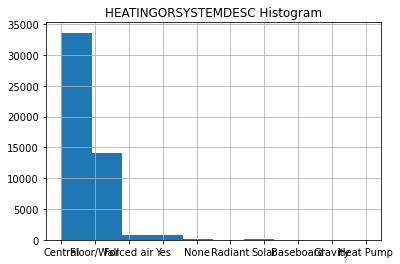

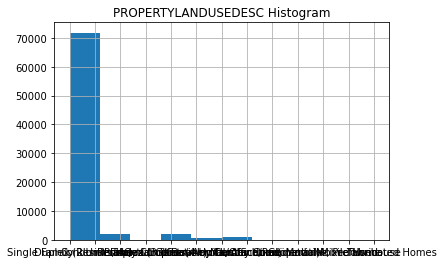

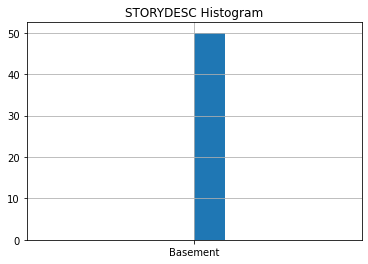

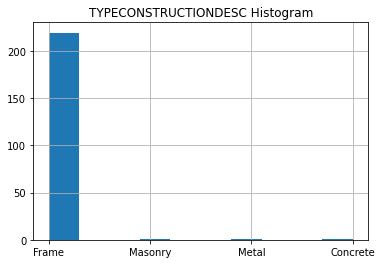

TypeError: Cannot perform 'rand_' with a dtyped [int64] array and scalar of type [bool]

In [87]:
visualize_data(zillow_df)

In [77]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)

num_cols = []

for col in zillow_df.columns:
    if zillow_df[col].dtype != 'O':
        num_cols.append(col)

print(pd.DataFrame({'min': zillow_df[num_cols].min(), 'max': zillow_df[num_cols].max(), 'range': zillow_df[num_cols].max() - zillow_df[num_cols].min()})\
.sort_values(by = ['range']))

                                       min           max         range
poolcnt                       1.000000e+00  1.000000e+00  0.000000e+00
assessmentyear                2.016000e+03  2.016000e+03  0.000000e+00
fireplaceflag                 1.000000e+00  1.000000e+00  0.000000e+00
storytypeid                   7.000000e+00  7.000000e+00  0.000000e+00
pooltypeid7                   1.000000e+00  1.000000e+00  0.000000e+00
pooltypeid2                   1.000000e+00  1.000000e+00  0.000000e+00
decktypeid                    6.600000e+01  6.600000e+01  0.000000e+00
pooltypeid10                  1.000000e+00  1.000000e+00  0.000000e+00
hashottuborspa                1.000000e+00  1.000000e+00  0.000000e+00
buildingclasstypeid           3.000000e+00  4.000000e+00  1.000000e+00
fireplacecnt                  1.000000e+00  5.000000e+00  4.000000e+00
numberofstories               1.000000e+00  6.000000e+00  5.000000e+00
threequarterbathnbr           1.000000e+00  7.000000e+00  6.000000e+00
typeco

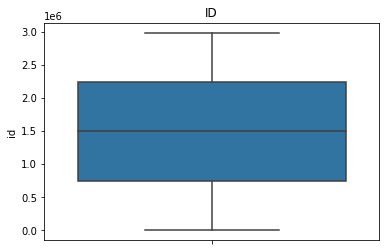

_____________________________________________


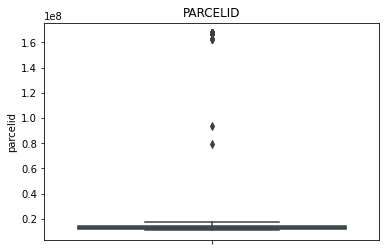

_____________________________________________


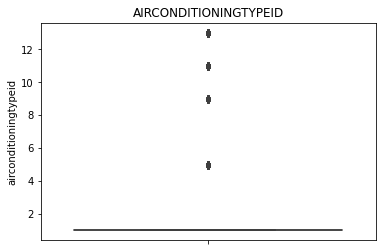

_____________________________________________


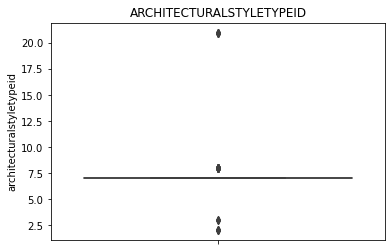

_____________________________________________


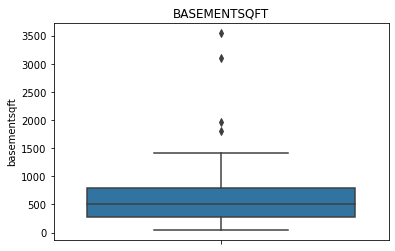

_____________________________________________


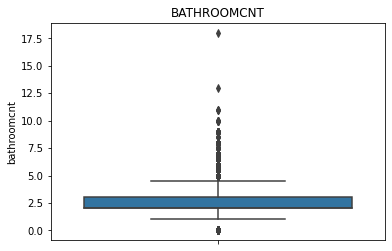

_____________________________________________


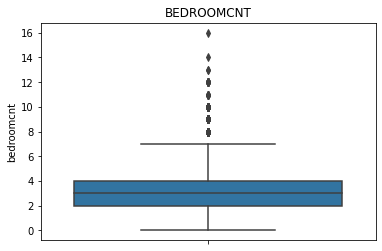

_____________________________________________


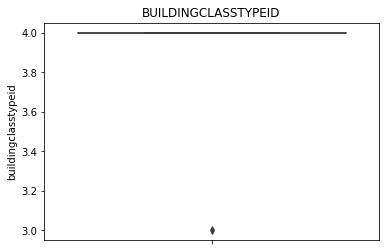

_____________________________________________


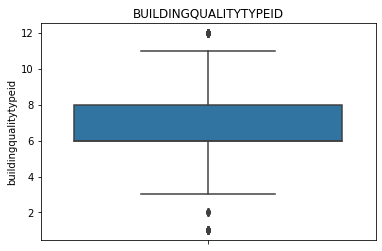

_____________________________________________


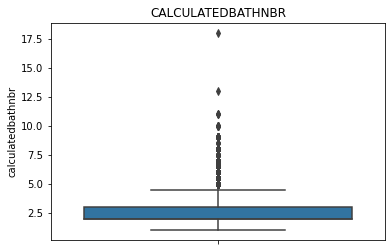

_____________________________________________


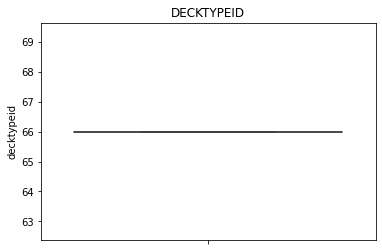

_____________________________________________


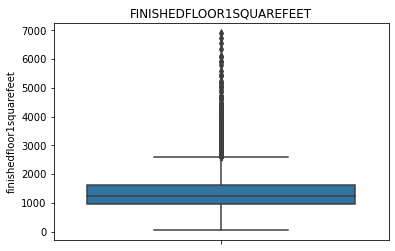

_____________________________________________


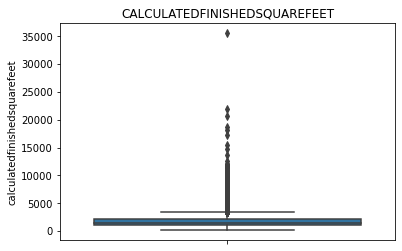

_____________________________________________


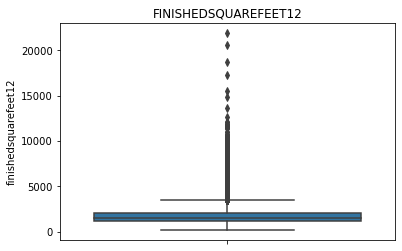

_____________________________________________


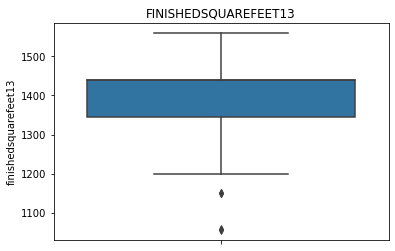

_____________________________________________


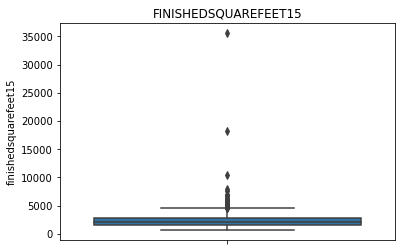

_____________________________________________


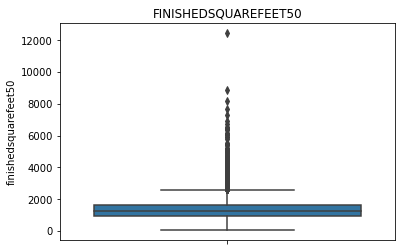

_____________________________________________


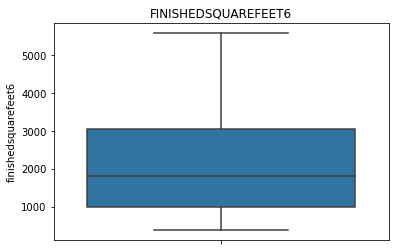

_____________________________________________


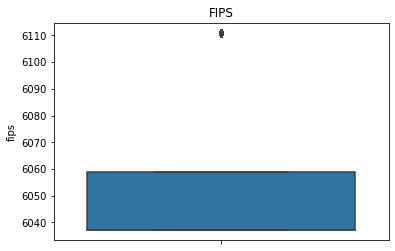

_____________________________________________


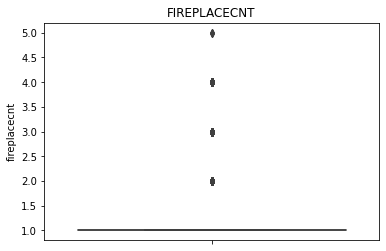

_____________________________________________


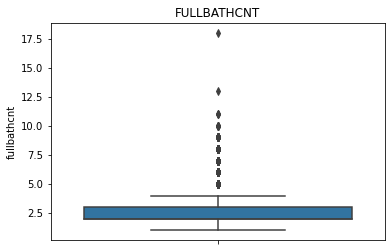

_____________________________________________


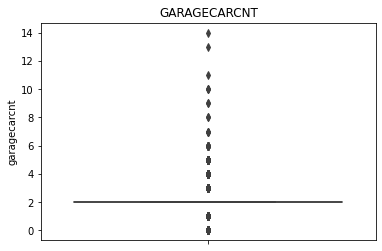

_____________________________________________


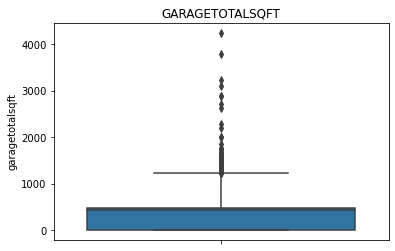

_____________________________________________


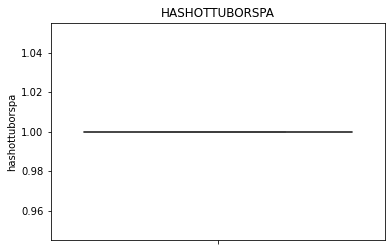

_____________________________________________


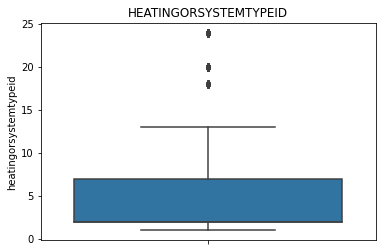

_____________________________________________


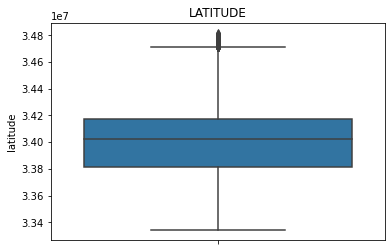

_____________________________________________


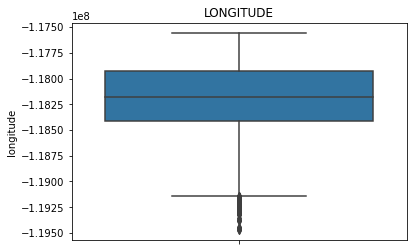

_____________________________________________


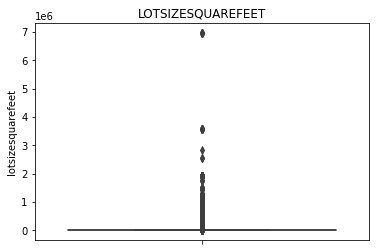

_____________________________________________


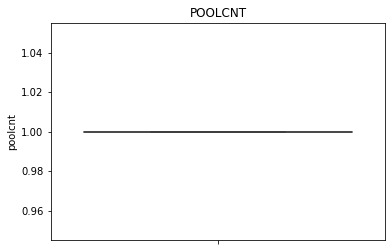

_____________________________________________


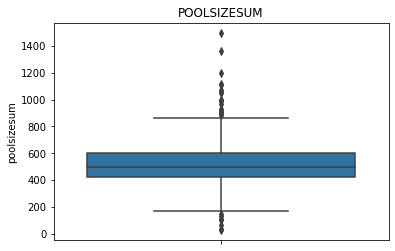

_____________________________________________


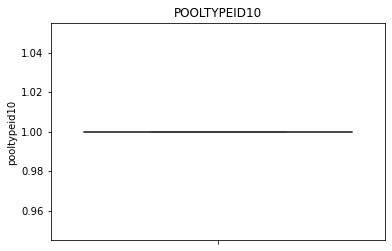

_____________________________________________


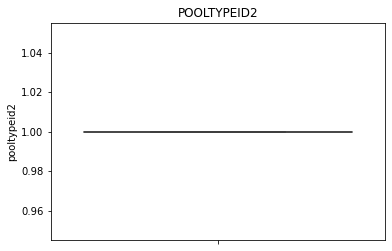

_____________________________________________


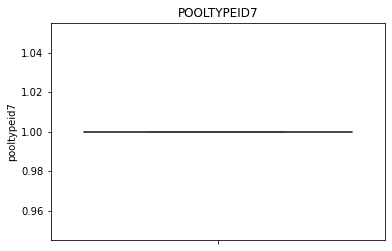

_____________________________________________


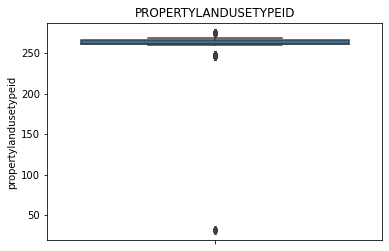

_____________________________________________


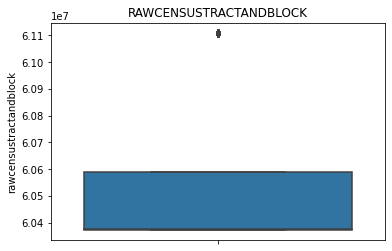

_____________________________________________


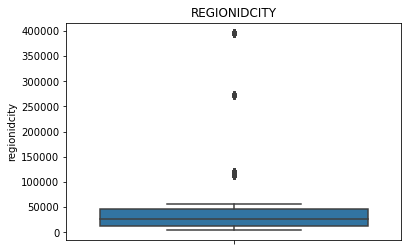

_____________________________________________


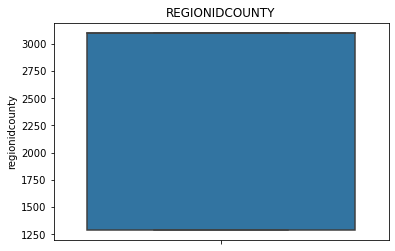

_____________________________________________


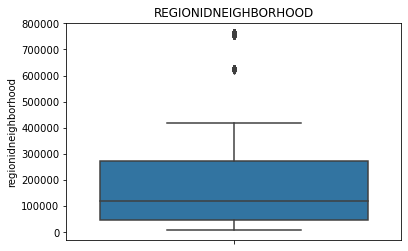

_____________________________________________


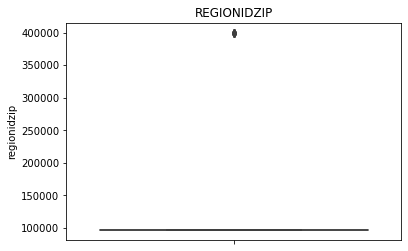

_____________________________________________


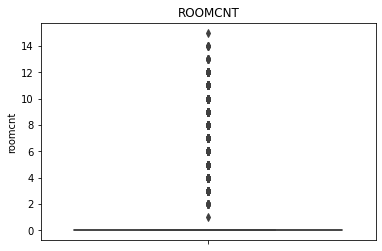

_____________________________________________


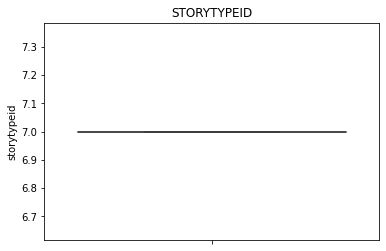

_____________________________________________


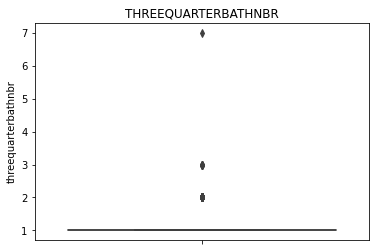

_____________________________________________


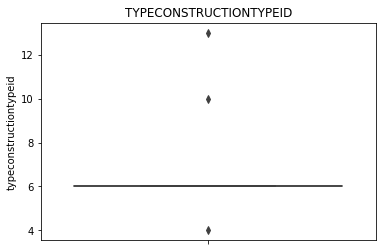

_____________________________________________


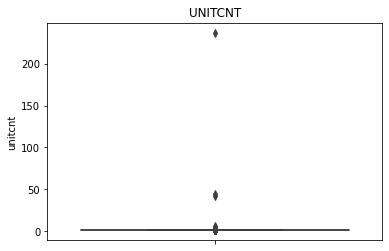

_____________________________________________


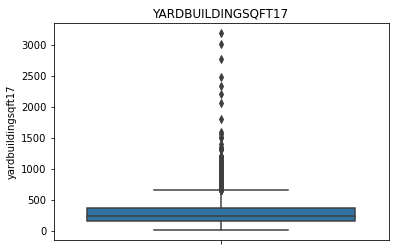

_____________________________________________


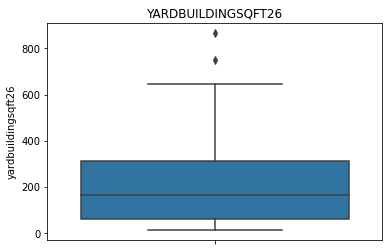

_____________________________________________


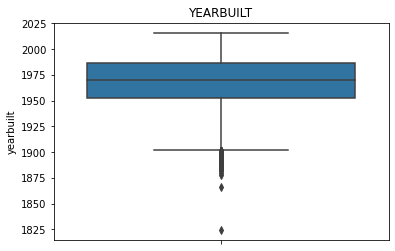

_____________________________________________


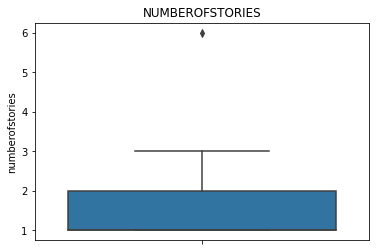

_____________________________________________


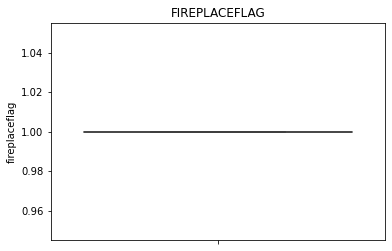

_____________________________________________


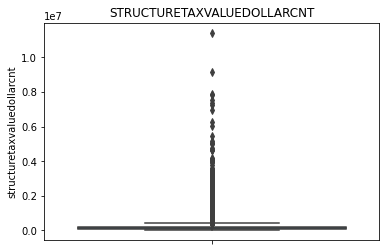

_____________________________________________


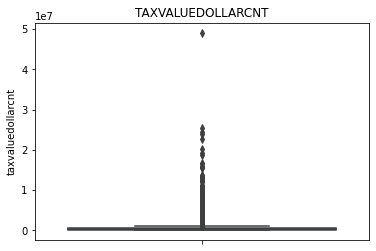

_____________________________________________


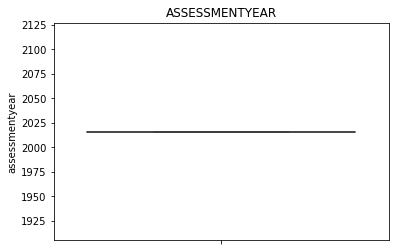

_____________________________________________


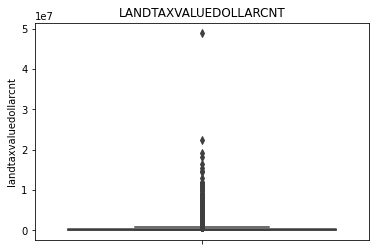

_____________________________________________


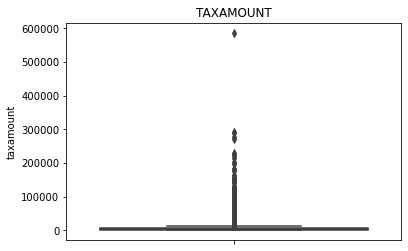

_____________________________________________


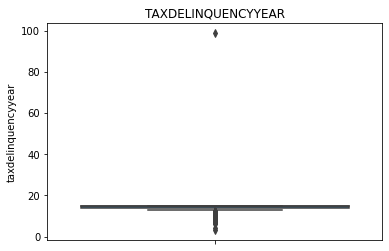

_____________________________________________


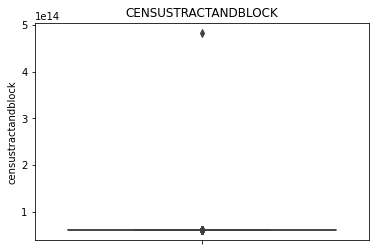

_____________________________________________


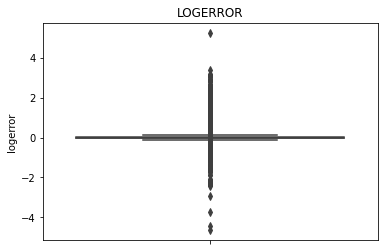

_____________________________________________


In [85]:
for col in zillow_df[num_cols]:
    
    sns.boxplot(y = zillow_df[col])
    plt.title(col.upper())
    plt.show()
    print('_____________________________________________')

### Prepare

### [`wrangle.py`](https://github.com/Jonessn22/clustering-exercises/blob/main/wrangle.py) 
> Create a module that uses the code above in a function that acquires and prepares Zillow data

# Mall Customers